# Data enrichment

This notebook aims to enrich the data to extract interesting metrics on broadcasters who have broadcast at least once with a Vtuber tag. We focus on the data that emanates from the videos available on each broadcaster's channel.

To do this, we first need to query all these videos.

And then we have to understand them at least a little bit.

## For general purpose

In [1]:
import requests
import json
import pandas as pd
import os

 # The .json with the CLIENT_ID and the TOKEN
with open('../twitch_credentials.json', mode='r') as f:
    twitch_credentials = json.load(f)

    # Twitch API variables
    CLIENT_ID = twitch_credentials['CLIENT_ID']
    TOKEN = twitch_credentials['TOKEN']
    
headers = {"Authorization":"Bearer " + TOKEN, "Client-Id":CLIENT_ID}

In [2]:
oldAPIStreams = pd.read_csv('../Data/twitch_streams_vtuber_tagIds.csv')
newAPIStreams = pd.read_csv('../Data/twitch_streams_vtuber_tagIds_tags.csv')

streams = pd.concat([oldAPIStreams, newAPIStreams], ignore_index=True).loc[:, ['user_id']].drop_duplicates()

## Querying and saving videos

In [3]:
from datetime import datetime

url = 'https://api.twitch.tv/helix/videos?first=100&user_id='
ratelimit = []

def get_user_archives(user_id):
    df_response = None
    try:
        response = requests.get(url + user_id, headers=headers)
        df_response = pd.DataFrame(response.json()["data"])

        # While there are other pages to get
        while len(response.json()["pagination"]) > 0 :
                response = requests.get(url + user_id + "&after=" + response.json()["pagination"]["cursor"], headers=headers)
                df_response = pd.concat([df_response, pd.DataFrame(response.json()["data"])])
                
                ratelimit.append(response.headers['Ratelimit-Remaining'])

        if 'stream_id' in df_response.columns: 
            return df_response.astype({'stream_id':'int64'})
        else:
            return None

    except:
        print(f"Error for user {user_id}")
        return df_response
        

def check_user(user_df):
    user_id = str(user_df['user_id'].iloc[0])
    return get_user_archives(user_id)

In [4]:
all_videos = streams.groupby('user_id').apply(check_user).reset_index(drop=True)

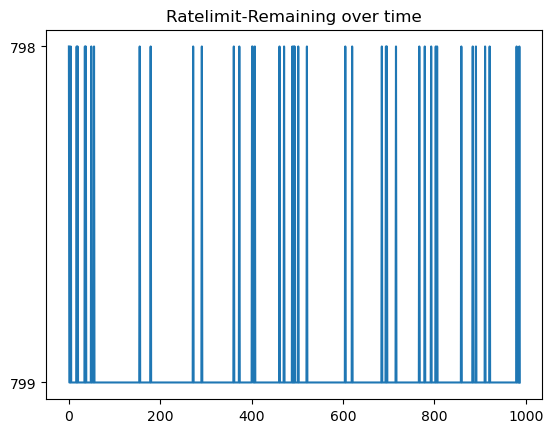

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(ratelimit)), y=ratelimit, )
plt.title('Ratelimit-Remaining over time');

In [6]:
all_videos.to_csv('./twitch_videos_vtuber_broadcaster.csv', index=False)

In [7]:
all_videos.groupby("user_name").view_count.sum().sort_values().tail()

user_name
Octoloth      48080
Pawa_Chan     48258
vanex_x       59610
MiyunaTV      84015
RiriMiaou    123265
Name: view_count, dtype: int64

In [10]:
import pandas as pd
import sys

df = pd.read_csv('twitch_videos_vtuber_broadcaster.csv')

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    all_videos: 31.1 MiB
                            df: 27.0 MiB
                 oldAPIStreams:  3.5 MiB
                 newAPIStreams:  2.5 MiB
                       streams: 16.4 KiB
                     ratelimit:  8.6 KiB
                           _i3:  1.1 KiB
                           _ii:  666.0 B
                           _i8:  666.0 B
                          _i10:  666.0 B


In [11]:
df.shape

(26052, 17)